#Train a generative adversarial network on a one-dimensional function
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/

In [227]:
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

#### Python Testing 

In [228]:
# hstack - Stack arrays in sequence horizontally (column wise).
x = (rand(3)*10).astype(int)
y = x*x
print(x)
print(y)
d = hstack([x,y])
print(d)

[3 3 3]
[9 9 9]
[3 3 3 9 9 9]


In [229]:
# hstack - Stack arrays in sequence horizontally (column wise).
x1 = x.reshape(3,1)
y1 = y.reshape(3,1)
print(x1)
print(y1)
d1 = hstack([x1,y1])
print(d1)

[[3]
 [3]
 [3]]
[[9]
 [9]
 [9]]
[[3 9]
 [3 9]
 [3 9]]


In [230]:
# ones
o = ones([3, 1])
print(o)

[[1.]
 [1.]
 [1.]]


In [231]:
z = zeros([3, 1])
print(z)

[[0.]
 [0.]
 [0.]]


In [232]:
# randn - Return a sample (or samples) from the “standard normal” distribution.
print(randn())
print(randn(3))
print(randn(2,2))

1.0485207089001092
[ 1.27778783  1.56579921 -1.20216227]
[[ 0.63022321  0.07368362]
 [-0.83454927  0.70173787]]


In [233]:
# Two-by-four array of samples from N(3, 6.25):
print(3 + 2.5 * randn(2, 4))

[[5.42761595 3.04342004 2.35876168 4.39119756]
 [2.27501517 3.86666696 2.8049318  1.33971759]]


# Define the D, G, and D+G models

In [234]:
# define the standalone discriminator model
# Inputs: Sample with two real values.
# Outputs: Binary classification, likelihood the sample is real (or fake)
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(16, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs)) # was 25
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(8, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim)) # was 16
	model.add(Dense(n_outputs, activation='linear'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan2trainG(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False # See comment block (***) below
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

(***) Only the discriminator is concerned with distinguishing between real and fake examples; therefore, the discriminator model can be trained in a standalone manner on examples of each.

The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

In [235]:
# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [-1.0, 1.0]
	X1 = 2.0*rand(n) - 1.0
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input, verbose=0) # verbose added 
	# create class labels
	y = zeros((n, 1))
	return X, y

# generate points in latent space as input for the generator
# Note that some points can be outside [-0.5, 0.5]
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

In [237]:
# tests when n=4
X,y= generate_real_samples(4)
print(X)
print(y)

[[-0.69718794  0.48607103]
 [ 0.66372328  0.4405286 ]
 [ 0.2373452   0.05633275]
 [-0.42484679  0.18049479]]
[[1.]
 [1.]
 [1.]
 [1.]]


array([[-0.96756282,  0.51823659,  0.64877224],
       [-0.18386954,  1.0025768 , -2.24851826],
       [ 0.74185681,  0.28446246, -0.24412958],
       [-0.09066359,  1.41537692, -0.0695478 ]])

In [241]:
generate_latent_points(3, 4) # dim and n

array([[-1.51866741, -1.75481703, -0.20134137],
       [ 0.86795505,  1.88915093, -2.2375141 ],
       [ 0.17652557, -0.189565  , -0.45104438],
       [-0.0640504 , -0.26927699,  0.26188411]])

In [242]:
gen = define_generator(3)
X_fake, y_fake = generate_fake_samples(gen, 3, 4)
print(X_fake)
print(y_fake)

[[ 1.5812509  -1.1930114 ]
 [ 0.10412543 -0.1171125 ]
 [-2.188666    0.8740974 ]
 [ 2.545197   -0.45812112]]
[[0.]
 [0.]
 [0.]
 [0.]]


## Train and Eval G & D

In [218]:
# train the generator and discriminator
#def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
def train(g_model, d_model, gan_model, latent_dim, n_epochs=3000, n_batch=128, n_eval=500):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator by showing both real and fake examples: train and improve D
		d_model.train_on_batch(x_real, y_real) # full-batch
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1)) # <====== important trick to fool the D. To minimize D's reward
		# update the generator via the discriminator's error: train / improve G
		gan_model.train_on_batch(x_gan, y_gan) # .fit
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)

In [219]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=80):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.show()

# Main

499 0.3499999940395355 0.6000000238418579


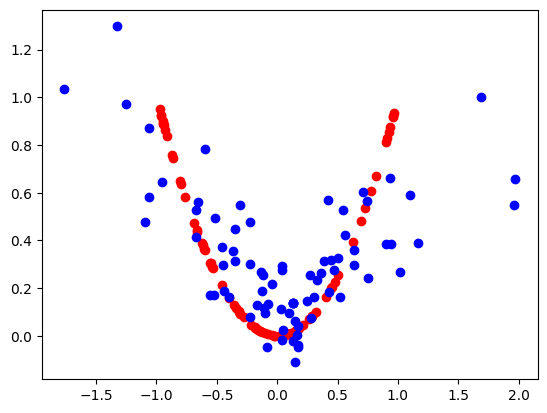

999 0.9750000238418579 0.22499999403953552


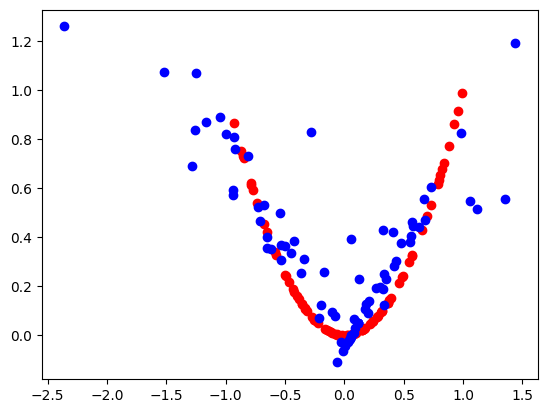

1499 0.862500011920929 0.3375000059604645


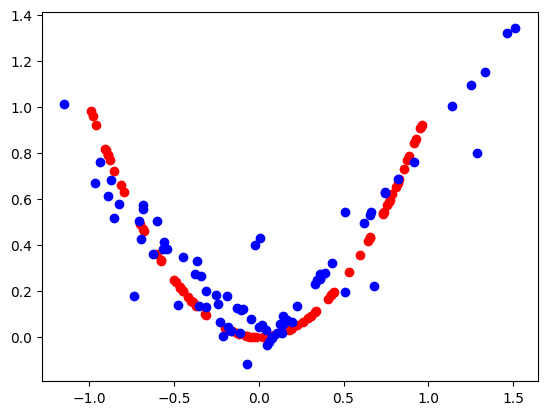

1999 0.800000011920929 0.3375000059604645


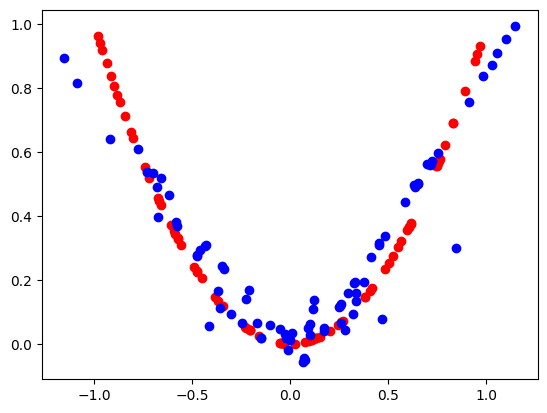

2499 0.6499999761581421 0.36250001192092896


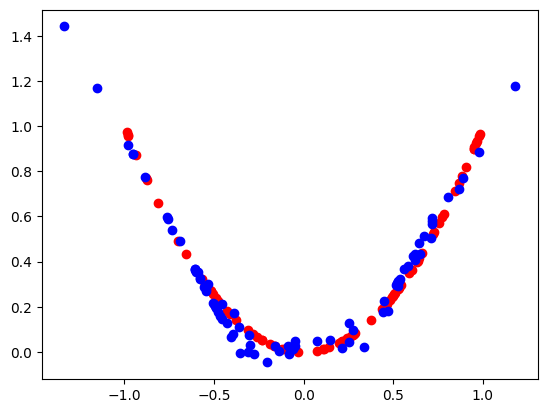

2999 0.4124999940395355 0.699999988079071


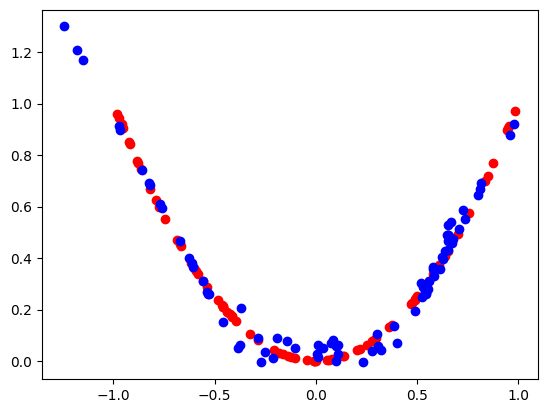

In [220]:
# size of the latent space
latent_dim = 3      # 6 did not work well...
# create the discriminator, just model, not trained
discriminator = define_discriminator()
# create the generator, just model, not trained
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan2trainG(generator, discriminator) 
# train model
train(generator, discriminator, gan_model, latent_dim) # call by assignment (like reference)